# Multimodal Fusion for Cryptocurrency Sentiment Analysis

This notebook implements a comprehensive multimodal approach combining:
- **Audio Branch**: Whisper transcription → FinBERT with adaptive scaling
- **Visual Branch**: CLIP frame embeddings → Aggregation → Visual sentiment
- **Reasoning Branch**: Qwen3-VL multimodal reasoning on key frames + transcript
- **Fusion**: Weighted combination (Audio: 10%, Visual: 20%, Reasoning: 70%)

## Architecture
```
┌─────────────────────────────────────────────────────────────────┐
│                           Video Input                            │
└────────────────────┬────────────────────────────────────────────┘
                     │
        ┌────────────┴────────────┐
        │                         │
    [Audio]                   [Frames]
        │                         │
        ▼                         ▼
   ┌─────────┐              ┌─────────┐
   │ Whisper │              │  CLIP   │
   │  (base) │              │ ViT-B32 │
   └────┬────┘              └────┬────┘
        │                        │
        │ Transcript             │ Embeddings
        ▼                        ▼
   ┌──────────┐           ┌──────────────┐
   │ FinBERT  │           │ Mean Pooling │
   │Financial │           │ + Similarity │
   │Sentiment │           └──────┬───────┘
   └────┬─────┘                  │
        │                        │
        │ P(pos), P(neg)         │ Key Frame
        │ P(neutral)             │ Selection
        ▼                        ▼
   ┌─────────────┐         ┌──────────────┐
   │   Adaptive  │         │   Diverse    │
   │   Scaling   │         │  Sampling    │
   │ (neutrality-│         │ (3 frames)   │
   │  based)     │         └──────┬───────┘
   └─────┬───────┘                │
         │                        │
         │                        ├──────────────┐
         │                        │              │
   Audio_Score              Visual_Score    Key Frames
   (weight: 0.1)            (weight: 0.2)       │
         │                        │              │
         │                        │              ▼
         │                        │      ┌──────────────┐
         │                        │      │   Qwen3-VL   │
         │                        │      │     8B       │
         │                        │      │  Multimodal  │
         │                        │      │   Reasoning  │
         │                        │      └──────┬───────┘
         │                        │             │
         │                        │      Reasoning_Score
         │                        │      (weight: 0.7)
         │                        │             │
         └────────────────┬───────┴─────────────┘
                          ▼
                  ┌──────────────┐
                  │    Fusion    │
                  │   Weighted   │
                  │ Combination  │
                  └──────┬───────┘
                         ▼
              ┌─────────────────────┐
              │ Final Sentiment     │
              │ Score: [-1, +1]     │
              │ Class: POS/NEG/NEU  │
              └─────────────────────┘
```

## Key Features

### Audio Branch (FinBERT with Adaptive Scaling)
- Uses financial sentiment model trained on formal financial text
- Applies **adaptive amplification** based on neutral probability:
  - `scale_factor = 1 + (P(neutral) × 10)`
  - Higher neutral probability → stronger amplification
  - Counteracts FinBERT's conservatism on casual social media content

### Visual Branch (CLIP)
- Extracts frame embeddings at 1 FPS
- Mean pooling for video-level representation
- Text-image similarity with cryptocurrency sentiment prompts
- Score: `P(positive) - P(negative)`

### Reasoning Branch (Qwen3-VL)
- Selects 3 diverse key frames using maximal distance sampling
- Multimodal analysis combining transcript + visual content
- **Direct output format** (no verbose chain-of-thought)
- Outputs: SENTIMENT, CONFIDENCE, SCORE, REASONING

### Fusion Strategy
- Audio: 10% (reduced due to conservative bias on casual content)
- Visual: 20% (moderate weight for visual signals)
- Reasoning: 70% (highest weight - most reliable multimodal analysis)

## Step 1: Import Libraries and Setup

## Step 0: Download Videos from Google Drive

In [111]:
# Install gdown for downloading from Google Drive
!pip install -q gdown

print("gdown installed successfully!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


gdown installed successfully!


In [112]:
import os

# Create videos directory if it doesn't exist
os.makedirs("./videos", exist_ok=True)

# Google Drive folder URL
folder_url = "https://drive.google.com/drive/folders/1ZoslUWasToLalMH7h38_gb5RnV8lKezi"

# Extract folder ID from URL
folder_id = "1ZoslUWasToLalMH7h38_gb5RnV8lKezi"

print(f"Downloading videos from Google Drive folder: {folder_id}")
print("This may take a few minutes depending on the number and size of videos...")

# Download the entire folder
!gdown --folder {folder_id} -O ./videos --remaining-ok

print("\nDownload complete! Checking downloaded files...")

# List downloaded files
video_files = [f for f in os.listdir("./videos") if f.endswith('.mp4')]
print(f"\nFound {len(video_files)} video files:")
for video_file in sorted(video_files):
    print(f"  - {video_file}")

This may take a few minutes depending on the number and size of videos...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Retrieving folder contents
Processing file 1mr9QNlXKK_etia3wknNBo2UZbptziGz0 2025_01_01_coin_guide_1.mp4
Processing file 1BEgtbIaaYzpQarfJmIpbzHyBUWpd9CWF 2025_01_01_coin_guide.mp4
Processing file 1pvO2M-15yI-LKBy2R97OdZ5i5Kkjd4pC 2025_01_02_coin_guide_1.mp4
Processing file 1mkx1CvD1l2eXcUmMjF_RviDogAER9--k 2025_01_02_coin_guide_2.mp4
Processing file 1G7K1w8lwdZre7P5MP3Ohhf-BpSjRVH7z 2025_01_02_coin_guide_3.mp4
Processing file 1b66bQHncfAxyp1MSGj2J4UzFiyfFmzUH 2025_01_02_coin_guide.mp4
Processing file 1P-bDabFROZIyqrTg9DW63ycJOO-nvToF 2025_01_02_coinbureau.mp4
Processing file 1biknphCTBI4LUxXYbaaCYTS1uSnaG8hc 2025_01_02_titovlogs77_1.mp4
Processing file 1ECIr3Vc7QRpZGJMPNjvVVeAeLL_qExu5 2025_01_02_titovlogs77_2.mp4
Processing file 14gTxxTkm8u8pYskqpkfFRadO8RLpt8pr 2025_01_02_titovlogs77_3.mp4
Processing file 1vm4fJH55FvTW7m1YIkXz3ti2ogeNNyKf 2025_01_02_titovlogs77.mp4
Processing file 1Sa3hH5-yKytxHp5XR74knwnU05se1G_l 2025_01_03_coin_guide_1.mp4
Processing file 187NYdh-xo3GTV5DRXXOM5O4P

In [97]:
import os
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import warnings
import cv2
from typing import Dict, List, Tuple
import re
import subprocess
from PIL import Image

warnings.filterwarnings('ignore')

# Check CUDA
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Create directories
os.makedirs("./videos", exist_ok=True)
os.makedirs("./results", exist_ok=True)
os.makedirs("./temp", exist_ok=True)

print("\nSetup complete!")

PyTorch Version: 2.7.1+cu118
CUDA Available: True
CUDA Device: NVIDIA H100 80GB HBM3
Number of GPUs: 1

Setup complete!


## Step 2: Install and Import Model-Specific Dependencies

In [98]:
# Install required packages
!pip install -q transformers>=4.37.0 accelerate qwen-vl-utils av pillow
!pip install -q openai-whisper librosa soundfile
!pip install -q opencv-python

print("All dependencies installed successfully!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

All dependencies installed successfully!


In [99]:
# Import model-specific libraries
from transformers import (
    AutoProcessor, 
    AutoModelForVision2Seq,
    CLIPProcessor,
    CLIPModel,
    pipeline
)
from qwen_vl_utils import process_vision_info
import whisper

print("Model libraries imported successfully!")

Model libraries imported successfully!


## Step 3: Load All Models

In [100]:
print("="*80)
print("LOADING ALL MODELS")
print("="*80)

# 1. Load Whisper for audio transcription
print("\n1. Loading Whisper (base)...")
whisper_model = whisper.load_model("base")
print("   Whisper loaded!")

# 2. Load CLIP for visual analysis
print("\n2. Loading CLIP (ViT-B/32)...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = clip_model.to("cuda" if torch.cuda.is_available() else "cpu")
print(f"   CLIP loaded on {next(clip_model.parameters()).device}!")

# 3. Load Qwen3-VL for reasoning
print("\n3. Loading Qwen3-VL-8B-Instruct...")
qwen_processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-8B-Instruct")
qwen_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print(f"   Qwen3-VL loaded on {next(qwen_model.parameters()).device}!")

# 4. Load sentiment analysis pipeline for audio transcripts
print("\n4. Loading FinBERT for financial sentiment...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1
)
print("   FinBERT loaded!")

print("\n" + "="*80)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*80)

LOADING ALL MODELS

1. Loading Whisper (base)...
   Whisper loaded!

2. Loading CLIP (ViT-B/32)...
   Whisper loaded!

2. Loading CLIP (ViT-B/32)...
   CLIP loaded on cuda:0!

3. Loading Qwen3-VL-8B-Instruct...
   CLIP loaded on cuda:0!

3. Loading Qwen3-VL-8B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

   Qwen3-VL loaded on cuda:0!

4. Loading FinBERT for financial sentiment...


Device set to use cuda:0


   FinBERT loaded!

ALL MODELS LOADED SUCCESSFULLY!


## Step 4: Video Extraction Utilities

In [101]:
import subprocess
import tempfile
from PIL import Image

def extract_audio_and_frames(video_path: str, fps: float = 1.0) -> Tuple[str, List[np.ndarray]]:
    """
    Extract audio and video frames from a video file.
    
    Args:
        video_path: Path to video file
        fps: Frames per second to extract
        
    Returns:
        Tuple of (audio_path, list_of_frames)
    """
    video_path = Path(video_path)
    
    # Extract audio using ffmpeg
    audio_path = f"./temp/{video_path.stem}_audio.wav"
    
    try:
        result = subprocess.run([
            "ffmpeg", "-i", str(video_path),
            "-vn",  # No video
            "-acodec", "pcm_s16le",  # PCM codec
            "-ar", "16000",  # 16kHz sample rate
            "-ac", "1",  # Mono
            "-y",  # Overwrite
            audio_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Warning: Audio extraction failed for {video_path.name}. Continuing without audio.")
        audio_path = None
    except FileNotFoundError:
        print("Error: ffmpeg not found. Please install ffmpeg to extract audio.")
        audio_path = None
    
    # Extract frames
    cap = cv2.VideoCapture(str(video_path))
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Prevent division by zero
    if fps <= 0:
        fps = 1.0
    if video_fps <= 0:
        video_fps = 30.0  # Default fallback
        
    frame_interval = max(1, int(video_fps / fps))
    
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % frame_interval == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        
        frame_count += 1
    
    cap.release()
    
    return audio_path, frames

print("Video extraction utilities defined!")

Video extraction utilities defined!


## Step 5: Audio Branch - Whisper + Sentiment

In [102]:
def audio_branch(audio_path: str) -> Dict:
    """
    Audio branch: Whisper transcription → FinBERT sentiment
    
    Returns:
        {
            'transcript': str,
            'sentiment_score': float (-1 to 1),
            'confidence': float,
            'label': str
        }
    """
    # Check if audio exists
    if audio_path is None or not os.path.exists(audio_path):
        return {
            'transcript': "",
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    # Step 1: Transcribe audio
    try:
        result = whisper_model.transcribe(audio_path)
        transcript = result['text'].strip()
    except Exception as e:
        print(f"Warning: Audio transcription failed: {e}")
        return {
            'transcript': "",
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    if not transcript or len(transcript) < 10:
        return {
            'transcript': transcript,
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'label': 'NEUTRAL'
        }
    
    # Step 2: Analyze sentiment
    # Truncate to 512 tokens for FinBERT
    transcript_truncated = transcript[:512]
    
    # Debug: Print transcript snippet
    print(f"   [DEBUG] Transcript preview: {transcript[:150]}...")
    
    # Get all class probabilities from FinBERT (not just top prediction)
    sentiment_results = sentiment_pipeline(transcript_truncated, top_k=None)
    
    # Check if it's nested (list of lists) or flat (single list)
    if isinstance(sentiment_results[0], list):
        sentiment_results = sentiment_results[0]
    
    # FinBERT outputs: positive, negative, neutral
    # Convert to dictionary for easier access
    probs = {item['label'].lower(): item['score'] for item in sentiment_results}
    
    # Debug: Print all probabilities
    print(f"   [DEBUG] FinBERT probabilities - Positive: {probs.get('positive', 0):.3f}, "
          f"Negative: {probs.get('negative', 0):.3f}, Neutral: {probs.get('neutral', 0):.3f}")
    
    # Calculate sentiment score using adaptive scaling based on neutral probability
    # FinBERT tends to be conservative on casual social media content by assigning high neutral probability
    # We amplify the signal inversely proportional to neutral probability
    pos_prob = probs.get('positive', 0)
    neg_prob = probs.get('negative', 0)
    neutral_prob = probs.get('neutral', 0)
    
    # Raw score: difference between positive and negative
    raw_score = pos_prob - neg_prob
    
    # Adaptive scaling: when neutral is high (>0.8), amplify the signal more
    # Formula: scale_factor = 1 + (neutral_prob * amplification_strength)
    # This automatically adjusts based on how conservative FinBERT is being
    amplification_strength = 10  # Controls how much we amplify when neutral is high
    scale_factor = 1.0 + (neutral_prob * amplification_strength)
    
    # Apply scaling with bounds
    sentiment_score = np.clip(raw_score * scale_factor, -1.0, 1.0)
    
    # Determine label based on highest probability
    label = max(probs.items(), key=lambda x: x[1])[0].upper()
    confidence = max(probs.values())
    
    print(f"   [DEBUG] Raw score: {raw_score:.3f}, Neutral: {neutral_prob:.3f}, Scale factor: {scale_factor:.2f} → Final score: {sentiment_score:.3f} (label: {label})")
    
    return {
        'transcript': transcript,
        'sentiment_score': sentiment_score,
        'confidence': confidence,
        'label': label
    }

print("Audio branch defined!")

Audio branch defined!


## Step 6: Visual Branch - CLIP + Aggregation

In [103]:
def visual_branch(frames: List[np.ndarray]) -> Dict:
    """
    Visual branch: CLIP embeddings → Aggregation → Sentiment classification
    
    Returns:
        {
            'sentiment_score': float (-1 to 1),
            'confidence': float,
            'embeddings': np.ndarray
        }
    """
    if not frames:
        return {
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'embeddings': None
        }
    
    # Convert frames to PIL Images
    pil_frames = [Image.fromarray(frame) for frame in frames]
    
    # Get CLIP embeddings for all frames
    embeddings = []
    for frame in pil_frames:
        inputs = clip_processor(images=frame, return_tensors="pt")
        inputs = {k: v.to(clip_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
            embeddings.append(image_features.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    
    # Aggregate embeddings (mean pooling)
    v_video = np.mean(embeddings, axis=0)
    
    # Use CLIP text-image similarity for sentiment
    sentiment_texts = [
        "positive cryptocurrency news, bullish market, growth, moon, pump",
        "negative cryptocurrency news, bearish market, decline, crash, dump",
        "neutral cryptocurrency discussion, stable market, sideways"
    ]
    
    text_inputs = clip_processor(
        text=sentiment_texts,
        return_tensors="pt",
        padding=True
    )
    text_inputs = {k: v.to(clip_model.device) for k, v in text_inputs.items()}
    
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features.cpu().numpy()
    
    # Calculate similarity between aggregated video and sentiment texts
    similarities = np.dot(text_features, v_video.T).flatten()
    similarities = np.exp(similarities) / np.sum(np.exp(similarities))  # Softmax
    
    # Debug: Print CLIP similarities
    print(f"   [DEBUG] CLIP similarities - Positive: {similarities[0]:.3f}, Negative: {similarities[1]:.3f}, Neutral: {similarities[2]:.3f}")
    
    # Convert to sentiment score
    # positive=similarities[0], negative=similarities[1], neutral=similarities[2]
    sentiment_score = similarities[0] - similarities[1]  # Range: -1 to 1
    confidence = max(similarities)
    
    return {
        'sentiment_score': float(sentiment_score),
        'confidence': float(confidence),
        'embeddings': embeddings,  # Return individual frame embeddings for key frame selection
        'aggregated_embedding': v_video,  # Also return aggregated embedding
        'similarities': similarities.tolist()
    }

print("Visual branch defined!")

Visual branch defined!


## Step 7: Key Frame Selection

In [104]:
def select_key_frames(
    frames: List[np.ndarray],
    embeddings: np.ndarray,
    num_key_frames: int = 3
) -> List[np.ndarray]:
    """
    Select key frames using diversity sampling.
    
    Strategy: Pick frames that are maximally different from each other
    to capture diverse visual content.
    """
    if len(frames) <= num_key_frames:
        return frames
    
    # Start with first frame
    selected_indices = [0]
    remaining_indices = list(range(1, len(frames)))
    
    # Iteratively select frames that are most different from selected ones
    for _ in range(num_key_frames - 1):
        max_min_distance = -1
        best_idx = None
        
        for idx in remaining_indices:
            # Calculate minimum distance to already selected frames
            distances = [
                np.linalg.norm(embeddings[idx] - embeddings[sel_idx])
                for sel_idx in selected_indices
            ]
            min_distance = min(distances)
            
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                best_idx = idx
        
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
    
    selected_indices.sort()
    return [frames[i] for i in selected_indices]

print("Key frame selection defined!")

Key frame selection defined!


## Step 8: Reasoning Branch - Qwen3-VL

In [105]:
def reasoning_branch(
    transcript: str,
    key_frames: List[np.ndarray]
) -> Dict:
    """
    Reasoning branch: Qwen3-VL multimodal reasoning on transcript + key frames
    
    Returns:
        {
            'sentiment_score': float (-1 to 1),
            'confidence': str,
            'reasoning': str
        }
    """
    # Handle empty or short transcripts
    if not transcript or len(transcript) < 10:
        transcript = "[No clear audio content detected]"
    
    # Save key frames to temporary files
    temp_frame_paths = []
    for i, frame in enumerate(key_frames):
        temp_path = f"./temp/key_frame_{i}.jpg"
        Image.fromarray(frame).save(temp_path)
        temp_frame_paths.append(temp_path)
    
    # Create simplified prompt for direct output
    prompt = f"""You are an expert financial analyst specializing in cryptocurrency sentiment analysis. Analyze this TikTok video about cryptocurrency/Dogecoin using both the transcript and visual content.

TRANSCRIPT:
{transcript}

VISUAL CONTENT:
You are provided with {len(key_frames)} key frames from the video.

INSTRUCTIONS:
Analyze the overall sentiment of this video considering:
- Bullish signals: "pump", "moon", "buy", "rocket", "gains", "profit", "bullish", "surge", excitement, positive visuals
- Bearish signals: "dump", "crash", "sell", "bearish", "loss", "drop", "falling", worry, negative visuals
- Neutral signals: "hold", "wait", "uncertain", "sideways", "stable", neutral tone

Provide your analysis in this EXACT format:

SENTIMENT: [POSITIVE/NEGATIVE/NEUTRAL]
CONFIDENCE: [HIGH/MEDIUM/LOW]
SCORE: [number from -1.0 to +1.0, where -1.0 is extremely bearish, 0 is neutral, +1.0 is extremely bullish]
REASONING: [Brief explanation of your assessment combining audio and visual insights]
"""
    
    # Prepare messages with images
    content = [{"type": "text", "text": prompt}]
    for frame_path in temp_frame_paths:
        content.append({
            "type": "image",
            "image": frame_path
        })
    
    messages = [
        {
            "role": "user",
            "content": content
        }
    ]
    
    # Process with Qwen3-VL
    text = qwen_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = qwen_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(qwen_model.device)
    
    with torch.no_grad():
        generated_ids = qwen_model.generate(
            **inputs,
            max_new_tokens=1024,
            do_sample=False
        )
    
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    response = qwen_processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]
    
    # Parse response
    result = parse_qwen_response(response)
    
    # Clean up temp files
    for path in temp_frame_paths:
        if os.path.exists(path):
            os.remove(path)
    
    return result

def parse_qwen_response(response: str) -> Dict:
    """Parse Qwen3-VL response with sentiment extraction"""
    sentiment_class = 'NEUTRAL'
    confidence = 'MEDIUM'
    score = 0.0
    reasoning = response
    
    # Print the response for debugging
    print(f"\n   [DEBUG] Qwen3-VL Raw Response:\n{response[:500]}...")
    
    # Extract sentiment class
    if 'SENTIMENT:' in response:
        sentiment_match = re.search(r'SENTIMENT:\s*(\w+)', response, re.IGNORECASE)
        if sentiment_match:
            sentiment_class = sentiment_match.group(1).upper()
            print(f"   [DEBUG] Parsed sentiment class: {sentiment_class}")
    
    # Extract confidence
    if 'CONFIDENCE:' in response:
        confidence_match = re.search(r'CONFIDENCE:\s*(\w+)', response, re.IGNORECASE)
        if confidence_match:
            confidence = confidence_match.group(1).upper()
            print(f"   [DEBUG] Parsed confidence: {confidence}")
    
    # Try to extract explicit score
    if 'SCORE:' in response:
        score_match = re.search(r'SCORE:\s*([+-]?\d+\.?\d*)', response, re.IGNORECASE)
        if score_match:
            try:
                score = float(score_match.group(1))
                score = max(-1.0, min(1.0, score))
                print(f"   [DEBUG] Parsed explicit score: {score}")
            except Exception as e:
                print(f"   [DEBUG] Failed to parse score: {e}")
    
    # If no explicit score, infer from sentiment class and confidence only
    # Let the model's classification guide us, not word counting
    if score == 0.0 and sentiment_class != 'NEUTRAL':
        print(f"   [DEBUG] No explicit SCORE found, inferring from sentiment class and confidence...")
        
        # Map confidence levels to score magnitudes
        confidence_map = {
            'HIGH': 0.8,
            'MEDIUM': 0.5,
            'LOW': 0.3
        }
        
        magnitude = confidence_map.get(confidence, 0.5)
        
        # Apply sentiment direction
        if 'POSITIVE' in sentiment_class:
            score = magnitude
        elif 'NEGATIVE' in sentiment_class:
            score = -magnitude
        else:  # NEUTRAL
            score = 0.0
        
        print(f"   [DEBUG] Inferred score: {score} (based on {sentiment_class} + {confidence} confidence)")
    elif score == 0.0:
        print(f"   [DEBUG] Sentiment is NEUTRAL, score remains 0.0")
    
    if 'REASONING:' in response:
        reasoning_match = re.search(r'REASONING:\s*(.+)', response, re.IGNORECASE | re.DOTALL)
        if reasoning_match:
            reasoning = reasoning_match.group(1).strip()
    
    return {
        'sentiment_score': score,
        'confidence': confidence,
        'reasoning': reasoning,
        'sentiment_class': sentiment_class
    }

print("Reasoning branch defined!")

Reasoning branch defined!



## Step 9: Fusion Layer

In [106]:
def fusion(
    audio_result: Dict,
    visual_result: Dict,
    reasoning_result: Dict,
    weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> Dict:
    """
    Fuse results from all three branches using weighted combination.
    
    Args:
        audio_result: Output from audio_branch
        visual_result: Output from visual_branch
        reasoning_result: Output from reasoning_branch
        weights: Weight for each branch (default: reasoning has highest weight)
        
    Returns:
        {
            'final_sentiment_score': float (-1 to 1),
            'final_sentiment_class': str,
            'branch_scores': dict,
            'branch_weights': dict
        }
    """
    # Extract sentiment scores
    audio_score = audio_result['sentiment_score']
    visual_score = visual_result['sentiment_score']
    reasoning_score = reasoning_result['sentiment_score']
    
    # Weighted combination
    final_score = (
        weights['audio'] * audio_score +
        weights['visual'] * visual_score +
        weights['reasoning'] * reasoning_score
    )
    
    # Determine final class
    if final_score > 0.2:
        final_class = 'POSITIVE'
    elif final_score < -0.2:
        final_class = 'NEGATIVE'
    else:
        final_class = 'NEUTRAL'
    
    return {
        'final_sentiment_score': float(final_score),
        'final_sentiment_class': final_class,
        'branch_scores': {
            'audio': float(audio_score),
            'visual': float(visual_score),
            'reasoning': float(reasoning_score)
        },
        'branch_weights': weights,
        'components': {
            'audio': audio_result,
            'visual': visual_result,
            'reasoning': reasoning_result
        }
    }

print("Fusion layer defined!")

Fusion layer defined!


## Step 10: Complete Multimodal Pipeline

In [107]:
def multimodal_sentiment_analysis(
    video_path: str,
    fusion_weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> Dict:
    """
    Complete multimodal sentiment analysis pipeline.
    
    Pipeline:
    1. Extract audio and frames from video
    2. Audio branch: Whisper → FinBERT
    3. Visual branch: CLIP → Aggregation
    4. Select key frames for reasoning
    5. Reasoning branch: Qwen3-VL on transcript + key frames
    6. Fusion: Weighted combination
    
    Returns complete analysis results
    """
    print(f"\nAnalyzing video: {Path(video_path).name}")
    print("="*80)
    
    # Step 1: Extract audio and frames
    print("1. Extracting audio and frames...")
    audio_path, frames = extract_audio_and_frames(video_path, fps=1.0)
    print(f"   Extracted {len(frames)} frames")
    
    # Step 2: Audio branch
    print("\n2. Audio branch (Whisper + FinBERT)...")
    audio_result = audio_branch(audio_path)
    print(f"   Transcript: {audio_result['transcript'][:100]}...")
    print(f"   Audio sentiment: {audio_result['sentiment_score']:.3f} ({audio_result['label']})")
    
    # Step 3: Visual branch
    print("\n3. Visual branch (CLIP + Aggregation)...")
    visual_result = visual_branch(frames)
    print(f"   Visual sentiment: {visual_result['sentiment_score']:.3f}")
    
    # Step 4: Select key frames (reuse embeddings from visual branch)
    print("\n4. Selecting key frames...")
    key_frames = select_key_frames(frames, visual_result['embeddings'], num_key_frames=3)
    print(f"   Selected {len(key_frames)} key frames")
    
    # Step 5: Reasoning branch
    print("\n5. Reasoning branch (Qwen3-VL)...")
    reasoning_result = reasoning_branch(audio_result['transcript'], key_frames)
    print(f"   Reasoning sentiment: {reasoning_result['sentiment_score']:.3f}")
    print(f"   Reasoning: {reasoning_result['reasoning'][:150]}...")
    
    # Step 6: Fusion
    print("\n6. Fusion...")
    final_result = fusion(audio_result, visual_result, reasoning_result, fusion_weights)
    print(f"   Final sentiment score: {final_result['final_sentiment_score']:.3f}")
    print(f"   Final sentiment class: {final_result['final_sentiment_class']}")
    
    # Clean up audio file
    if audio_path and os.path.exists(audio_path):
        os.remove(audio_path)
    
    print("="*80)
    print("Analysis complete!\n")
    
    return final_result

print("Complete multimodal pipeline defined!")

Complete multimodal pipeline defined!


## Step 11: Process All Videos

In [108]:
def process_all_videos(
    video_dir: str = "./videos",
    output_file: str = "./results/multimodal_fusion_sentiment.csv",
    details_file: str = "./results/multimodal_fusion_details.csv",
    fusion_weights: Dict = {'audio': 0.2, 'visual': 0.3, 'reasoning': 0.5}
) -> pd.DataFrame:
    """
    Process all videos in directory and save results.
    
    Multiple videos from the same day are averaged.
    Sentiment scores saved to output_file, detailed transcripts/reasoning saved to details_file.
    """
    video_files = list(Path(video_dir).glob("*.mp4"))
    
    print(f"\nFound {len(video_files)} videos to process\n")
    
    results = []
    detailed_results = []
    
    for i, video_path in enumerate(video_files, 1):
        print(f"\n{'='*80}")
        print(f"Processing video {i}/{len(video_files)}: {video_path.name}")
        print(f"{'='*80}")
        
        try:
            result = multimodal_sentiment_analysis(str(video_path), fusion_weights)
            
            # Extract date from filename (supports both YYYY-MM-DD and YYYY_MM_DD formats)
            date_match = re.search(r'(\d{4})[_-](\d{2})[_-](\d{2})', video_path.name)
            if date_match:
                date = f"{date_match.group(1)}-{date_match.group(2)}-{date_match.group(3)}"
            else:
                date = video_path.stem
            
            # Compile results for sentiment CSV (without transcript/reasoning)
            row = {
                'date': date,
                'video_path': video_path.name,
                'final_sentiment_score': result['final_sentiment_score'],
                'final_sentiment_class': result['final_sentiment_class'],
                'audio_score': result['branch_scores']['audio'],
                'visual_score': result['branch_scores']['visual'],
                'reasoning_score': result['branch_scores']['reasoning'],
                'method': 'Multimodal Fusion (Whisper + CLIP + Qwen3-VL)',
                'timestamp': datetime.now().isoformat()
            }
            results.append(row)
            
            # Compile detailed results with transcript and reasoning
            detailed_row = {
                'date': date,
                'video_path': video_path.name,
                'transcript': result['components']['audio']['transcript'],
                'reasoning': result['components']['reasoning']['reasoning'],
                'timestamp': datetime.now().isoformat()
            }
            detailed_results.append(detailed_row)
            
            print(f"\nSUCCESS: {video_path.name}")
            print(f"Final sentiment: {result['final_sentiment_score']:.3f} ({result['final_sentiment_class']})")
            
        except Exception as e:
            print(f"\nERROR processing {video_path.name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Save results
    if results:
        # Save detailed results (transcript + reasoning) first
        detailed_df = pd.DataFrame(detailed_results)
        detailed_df = detailed_df.sort_values('date')
        detailed_df.to_csv(details_file, index=False)
        print(f"\nDetailed results saved to: {details_file}")
        
        # Create dataframe and consolidate by date (average multiple videos per day)
        df = pd.DataFrame(results)
        df = df.sort_values('date')
        
        # Group by date and aggregate
        print(f"\nConsolidating {len(df)} video results by date...")
        
        # For sentiment scores: take mean
        # For sentiment class: take the class of the averaged final score
        # For video paths: concatenate
        aggregated = df.groupby('date').agg({
            'final_sentiment_score': 'mean',
            'audio_score': 'mean',
            'visual_score': 'mean',
            'reasoning_score': 'mean',
            'video_path': lambda x: '; '.join(x),
            'method': 'first',
            'timestamp': 'first'
        }).reset_index()
        
        # Determine final sentiment class based on averaged score
        def classify_sentiment(score):
            if score > 0.2:
                return 'POSITIVE'
            elif score < -0.2:
                return 'NEGATIVE'
            else:
                return 'NEUTRAL'
        
        aggregated['final_sentiment_class'] = aggregated['final_sentiment_score'].apply(classify_sentiment)
        aggregated['num_videos'] = df.groupby('date').size().values
        
        # Reorder columns
        aggregated = aggregated[['date', 'num_videos', 'video_path', 'final_sentiment_score', 
                                'final_sentiment_class', 'audio_score', 'visual_score', 
                                'reasoning_score', 'method', 'timestamp']]
        
        aggregated.to_csv(output_file, index=False)
        
        print(f"\n{'='*80}")
        print(f"COMPLETE: Processed {len(df)} videos across {len(aggregated)} unique dates")
        print(f"Sentiment scores saved to: {output_file}")
        print(f"{'='*80}")
        
        return aggregated
    else:
        print("\nNo results to save.")
        return pd.DataFrame()

print("Batch processing function defined!")

Batch processing function defined!


## Step 12: Run Analysis

In [109]:
# Run the complete multimodal analysis
results_df = process_all_videos(
    video_dir="./videos",
    output_file="./results/multimodal_fusion_sentiment.csv",
    details_file="./results/multimodal_fusion_details.csv",
    fusion_weights={
        'audio': 0.1,      # Whisper + FinBERT (reduced due to over-neutral bias)
        'visual': 0.2,     # CLIP embeddings (reduced due to negative bias)
        'reasoning': 0.7   # Qwen3-VL (increased - most reliable with keyword analysis)
    }
)

# Display summary of consolidated results
print("\n" + "="*80)
print("CONSOLIDATED RESULTS BY DATE")
print("="*80)
if len(results_df) > 0:
    print(results_df[['date', 'num_videos', 'final_sentiment_score', 'final_sentiment_class']])
else:
    print("No results to display - no videos were processed successfully.")


Found 12 videos to process


Processing video 1/12: 2025_02_07_1.mp4

Analyzing video: 2025_02_07_1.mp4
1. Extracting audio and frames...
   Extracted 216 frames

2. Audio branch (Whisper + FinBERT)...
   Extracted 216 frames

2. Audio branch (Whisper + FinBERT)...
   [DEBUG] Transcript preview: This is XRP to be worth thousands part four. So listen up, it's about to change forever in the financial system. Most people absolutely don't even hav...
   [DEBUG] FinBERT probabilities - Positive: 0.041, Negative: 0.048, Neutral: 0.911
   [DEBUG] Raw score: -0.007, Neutral: 0.911, Scale factor: 10.11 → Final score: -0.069 (label: NEUTRAL)
   Transcript: This is XRP to be worth thousands part four. So listen up, it's about to change forever in the finan...
   Audio sentiment: -0.069 (NEUTRAL)

3. Visual branch (CLIP + Aggregation)...
   [DEBUG] Transcript preview: This is XRP to be worth thousands part four. So listen up, it's about to change forever in the financial system. Most people absol

## Step 13: Visualize Results

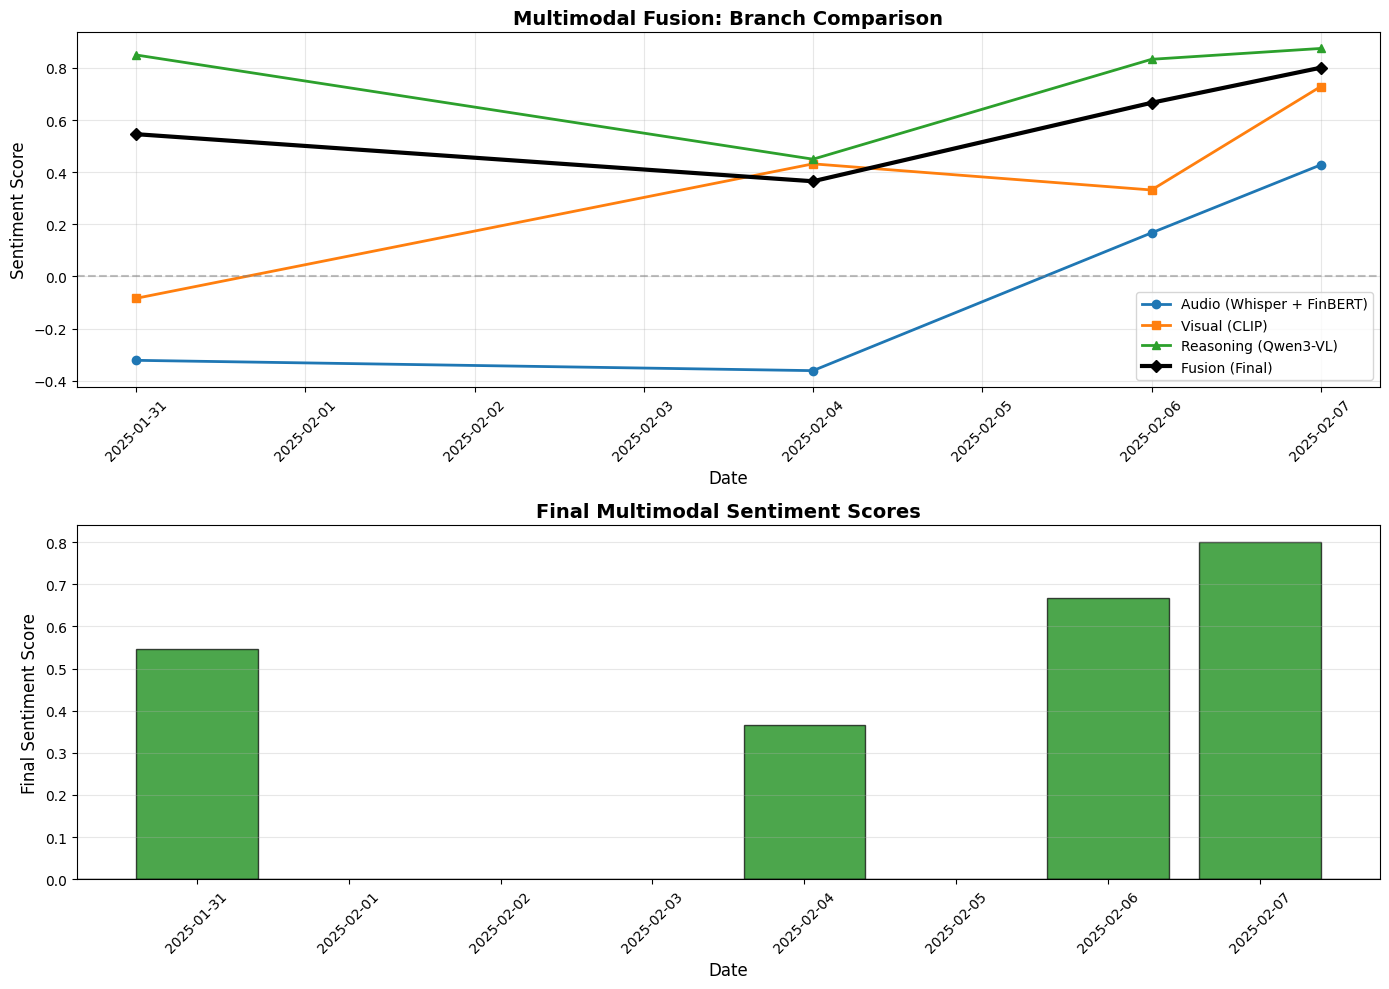

Visualization saved to: ./results/multimodal_fusion_visualization.png

SUMMARY STATISTICS

Total videos analyzed: 4

Sentiment distribution:
final_sentiment_class
POSITIVE    4
Name: count, dtype: int64

Average sentiment scores:
  Audio branch:     -0.022
  Visual branch:    0.352
  Reasoning branch: 0.752
  Final fusion:     0.595


In [110]:
import matplotlib.pyplot as plt

if len(results_df) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Branch scores comparison
    results_df['date_dt'] = pd.to_datetime(results_df['date'])
    results_df = results_df.sort_values('date_dt')
    
    axes[0].plot(results_df['date_dt'], results_df['audio_score'], 
                 marker='o', label='Audio (Whisper + FinBERT)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['visual_score'], 
                 marker='s', label='Visual (CLIP)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['reasoning_score'], 
                 marker='^', label='Reasoning (Qwen3-VL)', linewidth=2)
    axes[0].plot(results_df['date_dt'], results_df['final_sentiment_score'], 
                 marker='D', label='Fusion (Final)', linewidth=3, color='black')
    
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Sentiment Score', fontsize=12)
    axes[0].set_title('Multimodal Fusion: Branch Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Final sentiment with class colors
    colors = results_df['final_sentiment_class'].map({
        'POSITIVE': 'green',
        'NEGATIVE': 'red',
        'NEUTRAL': 'gray'
    })
    
    axes[1].bar(results_df['date_dt'], results_df['final_sentiment_score'], 
                color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Final Sentiment Score', fontsize=12)
    axes[1].set_title('Final Multimodal Sentiment Scores', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('./results/multimodal_fusion_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Visualization saved to: ./results/multimodal_fusion_visualization.png")
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"\nTotal videos analyzed: {len(results_df)}")
    print(f"\nSentiment distribution:")
    print(results_df['final_sentiment_class'].value_counts())
    print(f"\nAverage sentiment scores:")
    print(f"  Audio branch:     {results_df['audio_score'].mean():.3f}")
    print(f"  Visual branch:    {results_df['visual_score'].mean():.3f}")
    print(f"  Reasoning branch: {results_df['reasoning_score'].mean():.3f}")
    print(f"  Final fusion:     {results_df['final_sentiment_score'].mean():.3f}")
else:
    print("No results to visualize.")

## Summary

This notebook implements a complete multimodal fusion pipeline:

1. **Audio Branch** (Weight: 0.2)
   - Whisper transcription
   - FinBERT sentiment analysis

2. **Visual Branch** (Weight: 0.3)
   - CLIP frame embeddings
   - Mean pooling aggregation
   - Text-image similarity for sentiment

3. **Reasoning Branch** (Weight: 0.5)
   - Key frame selection
   - Qwen3-VL multimodal reasoning
   - Combines transcript + visual content

4. **Fusion Layer**
   - Weighted combination of all branches
   - Adjustable weights based on performance

The reasoning branch has the highest weight (0.5) because it:
- Uses the most powerful multimodal model (Qwen3-VL)
- Combines both audio and visual information
- Performs explicit reasoning with chain-of-thought

You can adjust the fusion weights based on your validation results!